In [1]:
### Training a CNN using gradient_tape to 'manually' grab the gradients and updating the weights of the network ###

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, losses
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from collections import Counter
print(tf.__version__)

2.1.0


In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
num_classes = 10

In [4]:
### Data exploration ###
print(type(train_images))
print('train_images.shape = ', train_images.shape)
print('train_labels.shape = ', train_labels.shape)
print('test_images.shape = ', test_images.shape)
print('test_labels.shape = ', test_labels.shape)

<class 'numpy.ndarray'>
train_images.shape =  (50000, 32, 32, 3)
train_labels.shape =  (50000, 1)
test_images.shape =  (10000, 32, 32, 3)
test_labels.shape =  (10000, 1)


In [5]:
### Data exploration - outputs ###
set_labels = set(np.reshape(train_labels, (-1)))
train_count = Counter(np.reshape(train_labels, (-1)))
test_count = Counter(np.reshape(test_labels, (-1)))
print('labels = ', set_labels)
print('train_count = ', train_count)
print('test_count = ', test_count)

labels =  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
train_count =  Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
test_count =  Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


In [6]:
### Converting to one-hot encoding ###
train_labels = np.array(tf.one_hot(train_labels, depth = num_classes))
test_labels = np.array(tf.one_hot(test_labels, depth = num_classes))

In [7]:
train_labels = np.reshape(train_labels, (-1, num_classes))
test_labels = np.reshape(test_labels, (-1, num_classes))
print('train_labels.shape = ', train_labels.shape)
print('test_labels.shape = ', test_labels.shape)
print('train_labels[0] = ', train_labels[0])

train_labels.shape =  (50000, 10)
test_labels.shape =  (10000, 10)
train_labels[0] =  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [8]:
### Data exploration - inputs ###
print(type(train_images[0]))
min_input_value = min(np.min(train_images), np.min(test_images))
max_input_value = max(np.max(train_images), np.max(test_images))
print('min_input_value = ', min_input_value)
print('max_input_value = ', max_input_value)

<class 'numpy.ndarray'>
min_input_value =  0
max_input_value =  255


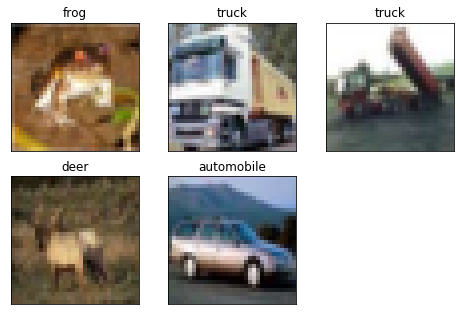

In [9]:
### Plotting a few images ###
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_examples(x, y = None, figsize = (8, 8)):
    
    ncols = math.ceil(len(x) ** (1/2))
    nrows = ncols
    plt.figure(figsize = figsize)
    
    for i in range(len(x)):
        ax = plt.subplot(nrows, ncols, i+1)
        plt.imshow(x[i])
        if y.any():
            plt.title(class_names[np.argmax(y[i])])
        plt.xticks([])
        plt.yticks([])
    

            
plot_examples(train_images[:5], train_labels[:5])

In [10]:
### Normalization ###
train_images = train_images / 255
test_images = test_images / 255

In [11]:
### Converting to tf.dataset ###
batch_size = 32
limit = 1200
train_ds = tf.data.Dataset.from_tensor_slices((train_images[:limit], train_labels[:limit])).shuffle(buffer_size = 1000, 
                                                                                    reshuffle_each_iteration = True).batch(batch_size)
print('Done half')
test_ds = tf.data.Dataset.from_tensor_slices((test_images[:limit], test_labels[:limit])).batch(batch_size)
print('Done')

Done half
Done


In [12]:
### Testing the dataset and batches ###
i = 0
for images, labels in train_ds:
    print(i)
    print(type(images), images.shape)
    print(type(labels), labels.shape)
    print(images)
    print(labels)
    i += 1
    if i > 0:
        break

0
<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 32, 32, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 10)
tf.Tensor(
[[[[0.11764706 0.06666667 0.07843137]
   [0.10980392 0.05882353 0.0745098 ]
   [0.10588235 0.05490196 0.07058824]
   ...
   [0.10588235 0.01960784 0.05098039]
   [0.09803922 0.01960784 0.04313725]
   [0.08627451 0.01568627 0.03921569]]

  [[0.12941176 0.09803922 0.09803922]
   [0.1254902  0.09411765 0.09411765]
   [0.1254902  0.09411765 0.09411765]
   ...
   [0.10980392 0.02745098 0.05490196]
   [0.10196078 0.02745098 0.05098039]
   [0.09411765 0.02352941 0.04705882]]

  [[0.14509804 0.12941176 0.11764706]
   [0.1372549  0.1254902  0.10980392]
   [0.1372549  0.12156863 0.10588235]
   ...
   [0.12156863 0.03529412 0.06666667]
   [0.10980392 0.03529412 0.05882353]
   [0.09803922 0.03137255 0.05490196]]

  ...

  [[0.18431373 0.16862745 0.14509804]
   [0.19607843 0.18431373 0.14509804]
   [0.25098039 0.24313725 0.18823529]
   ...
   [0.2        

In [23]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), input_shape = (32, 32, 3), activation = 'relu'))#, data_format='channels_last'))
model.add(layers.Dropout(rate = 0.5))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.Dropout(rate = 0.5))

model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.Dropout(rate = 0.5))

model.add(layers.Flatten())
model.add(layers.Dense(num_classes, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)         

In [24]:
### Choosing optimizer and compiling ###
opt = optimizers.Adam(learning_rate = 0.001)
loss_func = losses.CategoricalCrossentropy()
acc_func = tf.keras.metrics.CategoricalAccuracy()
#model.compile(opt, loss = loss_func, metrics = ['accuracy'])

In [25]:
### Function for training a single batch ###
def train_one_batch(x, y, loss_func, acc_func = None):
    
    with tf.GradientTape() as tape:
        preds = model(x, training = True)
        loss = loss_func(y, preds)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    if acc_func:
        acc = acc_func(y, preds)
    
    return loss, acc

In [26]:
### Function for validating a single batch ###
def validate_one_batch(x, y, loss_func, acc_func = None):
    
    preds = model(x, training = False)
    loss = loss_func(y, preds)
    
    if acc_func:
        acc = acc_func(y, preds)
    
    return loss, acc

In [27]:
y = [[0.1, 0.9, 0.8], [0.05, 0.95, 0]]
pred = [[0, 0, 1], [0, 1, 0]]
acc = tf.keras.metrics.CategoricalAccuracy()
res = acc(y, pred)
print(type(res), float(res))

<class 'tensorflow.python.framework.ops.EagerTensor'> 0.5


In [28]:
### Function for training the model ###
def train_model(model, train_ds, test_ds, epochs, loss_func, acc_func):
    
    tot_t_start = time.time()
    
    loss = []
    val_loss = []
    acc = []
    val_acc = []
    
    for ep in range(epochs):
        
        t_start = time.time()
        
        ep_loss = []
        ep_val_loss = []
        ep_acc = []
        ep_val_acc = []
        
        # Iterating over the training set in batches
        for images, labels in train_ds:
            batch_loss, batch_acc = train_one_batch(images, labels, loss_func, acc_func)
            batch_loss = float(batch_loss)
            batch_acc = float(batch_acc)
            ep_loss.append(batch_loss)
            ep_acc.append(batch_acc)
            
        # Iterating over the validation set in batches
        for images, labels in test_ds:
            batch_loss, batch_acc = train_one_batch(images, labels, loss_func, acc_func)
            batch_loss, batch_acc = float(batch_loss), float(batch_acc)
            ep_val_loss.append(batch_loss)
            ep_val_acc.append(batch_acc)
        
        # Keeping track of the loss
        loss.append(np.mean(ep_loss))
        val_loss.append(np.mean(ep_val_loss))
        
        # Keeping track of the accuracy
        acc.append(np.mean(ep_acc))
        val_acc.append(np.mean(ep_val_acc))
        
        time_taken = time.time() - t_start
        
        print(f'Epoch {ep+1}:     ',
              f'loss = {round(loss[-1], 5):<10}',
              f'val_loss = {round(val_loss[-1], 5):<10}',
              f'acc = {round(acc[-1], 5):<10}',
              f'val_acc = {round(val_acc[-1], 5):<10}',
              f'time = {round(time_taken, 2):<10}')
        
    print(f'Total time taken = {round(time.time() - tot_t_start, 2)} seconds')
    return loss, val_loss, acc, val_acc

In [ ]:
loss, val_loss, acc, val_acc = train_model(model, train_ds, test_ds, 50, loss_func, acc_func)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1:      loss = 2.67979    val_loss = 2.44109    acc = 0.09095    val_acc = 0.10694    time = 17.76     
Epoch 2:      loss = 2.2995     val_loss = 2.23215    acc = 0.1141     val_acc = 0.12853    time = 17.45     
Epoch 3:      loss = 2.18554    val_loss = 2.20065    acc = 0.13909    val_acc = 0.14819    time = 16.19     
Epoch 4:      loss = 2.10891    val_loss = 2.11123    acc = 0.15437    val_acc = 0.16212    time = 15.92     
Epoch 5:      loss = 2.0925     val_loss = 2.04043    acc = 0.16934 

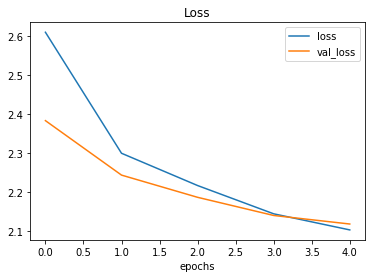

In [20]:
### Evaluating the model - loss ###
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

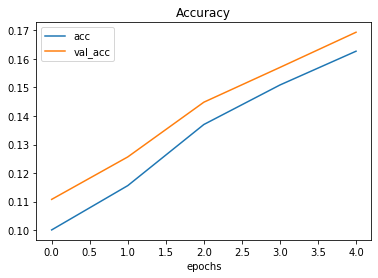

In [21]:
### Evaluating the model - accuracy ###
plt.plot(acc, label = 'acc')
plt.plot(val_acc, label = 'val_acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()